### 🏿 GPU and CUDA

In [2]:
from psutil import virtual_memory       
gpu = !nvidia-smi --query-gpu=gpu_name --format=csv,noheader
ram_gb = virtual_memory().total / 1e9
print(f'{gpu.s} with {round(ram_gb,1)} GB of available RAM.\n')
!nvcc --version

NVIDIA GeForce RTX 3090 with 34.2 GB of available RAM.

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_22:08:44_Pacific_Standard_Time_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0


### ⚙️ Configurations

In [15]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy  # binary cross-entropy          
from tensorflow.keras.metrics import Precision 
from tensorflow.keras.metrics import Recall
from segmentation_models.metrics import IOUScore        # Jaccard index

CONFIGS = dict(
    BATCH_SZ = 4,
    IMG_SIZE = (256, 256),   
    SEED = 42,               
    CLASS_NUM = 1,
    REF_FILTERS = 128,      # reference number for U-NET filters
    F_INIT = "he_normal",   # Kaiming He initialization    
    EPOCHS = 100,           # training epochs
    OPTIMIZER = Adam(learning_rate=0.001), 
    LOSS = BinaryCrossentropy(label_smoothing=0.1),              
    CONV_ACTIV = Activation(tf.nn.relu),    
    DTYPE = np.float32,                      
    METRICS = [IOUScore(threshold = 0.5),
               Precision(thresholds=0.5), 
               Recall(thresholds=0.5)],
)

# import tensorflow.keras.backend as backend
# # forces channel-last order (L,A,C)
# backend.set_image_data_format('channels_last')#

ModuleNotFoundError: No module named 'tensorflow.keras'

In [16]:
!pip uninstall -y tensorflow-gpu

Found existing installation: tensorflow-gpu 2.10.1
Uninstalling tensorflow-gpu-2.10.1:
  Successfully uninstalled tensorflow-gpu-2.10.1


ERROR: Exception:
Traceback (most recent call last):
  File "C:\Users\tiago\miniconda3\envs\tf2_10\lib\site-packages\pip\_internal\cli\base_command.py", line 167, in exc_logging_wrapper
    status = run_func(*args)
  File "C:\Users\tiago\miniconda3\envs\tf2_10\lib\site-packages\pip\_internal\commands\uninstall.py", line 103, in run
    uninstall_pathset.commit()
  File "C:\Users\tiago\miniconda3\envs\tf2_10\lib\site-packages\pip\_internal\req\req_uninstall.py", line 424, in commit
    self._moved_paths.commit()
  File "C:\Users\tiago\miniconda3\envs\tf2_10\lib\site-packages\pip\_internal\req\req_uninstall.py", line 277, in commit
    save_dir.cleanup()
  File "C:\Users\tiago\miniconda3\envs\tf2_10\lib\site-packages\pip\_internal\utils\temp_dir.py", line 173, in cleanup
    rmtree(self._path)
  File "C:\Users\tiago\miniconda3\envs\tf2_10\lib\site-packages\pip\_vendor\tenacity\__init__.py", line 326, in wrapped_f
    return self(f, *args, **kw)
  File "C:\Users\tiago\miniconda3\envs\tf2_

In [18]:
!pip install tensorflow-gpu==2.10.0

^C


     -------------------------------------- 455.9/455.9 MB 2.9 MB/s eta 0:00:00
  Using cached keras-2.10.0-py2.py3-none-any.whl (1.7 MB)
  Using cached tensorboard-2.10.1-py3-none-any.whl (5.9 MB)
  Using cached tensorflow_estimator-2.10.0-py2.py3-none-any.whl (438 kB)
  Attempting uninstall: keras
    Found existing installation: keras 2.11.0
    Uninstalling keras-2.11.0:
      Successfully uninstalled keras-2.11.0
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.11.0
    Uninstalling tensorflow-estimator-2.11.0:
      Successfully uninstalled tensorflow-estimator-2.11.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.11.2
    Uninstalling tensorboard-2.11.2:
      Successfully uninstalled tensorboard-2.11.2


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-intel 2.11.0 requires keras<2.12,>=2.11.0, but you have keras 2.10.0 which is incompatible.
tensorflow-intel 2.11.0 requires tensorboard<2.12,>=2.11, but you have tensorboard 2.10.1 which is incompatible.
tensorflow-intel 2.11.0 requires tensorflow-estimator<2.12,>=2.11.0, but you have tensorflow-estimator 2.10.0 which is incompatible.


### 📁 Data source paths and directory creation

In [3]:
import os
from glob import glob
DIR = os.getcwd()
ANN_FILE = os.path.join(DIR, 'data_800_600\\result.json')
IMGS_DIR = os.path.join(DIR, 'data_800_600\\images')
MSKS_DIR = os.path.join(DIR, 'data_800_600\\masks')
NO_LABEL_DIR = os.path.join(DIR, 'output_Waternet')
imgs_no_lbl_paths = sorted(glob(NO_LABEL_DIR + '\\C5\\**\\*.png', recursive=True) +
                           glob(NO_LABEL_DIR + '\\C6\\**\\*.png', recursive=True)) 
CHCKPNT_MODELS = os.path.join(DIR, 'checkpoints\\deeplabv3plus\\deeplabv3')
LOGS = os.path.join(DIR, 'logs\\deeplabv3')
os.makedirs(LOGS, exist_ok=True)

In [1]:
import os
DIR = os.getcwd()
ANN_FILE = os.path.join(DIR, 'data\\result.json')
MSKS_DIR = os.path.join(DIR, 'data\\masks')
IMGS_DIR = os.path.join(DIR, 'data\\images')
NO_LABEL_DIR = os.path.join(DIR, 'output_MSRCR_total')
CHCKPNT_MODELS = os.path.join(DIR, 'checkpoints\\deeplabv3')
BATCH_SIZE = 4
IMG_SIZE = (512,512)
SEED = 42

# COCO format dataset 

In [4]:
# for Windows, install pycocotools with conda
import pycocotools
from pycocotools.coco import COCO
dset = COCO(ANN_FILE)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


## DeepLabV3+ Segmentation Model

 ![](deeplabv3_plus_diagram.png "DeepLabV3++ Diagram")

### DeepLabV3+ Backbones

In [19]:
# https://www.researchgate.net/publication/354108791_Estimation_of_Road_Boundary_for_Intelligent_Vehicles_Based_on_DeepLabV3_Architecture/figures?lo=1
from IPython.display import Image, display
display(Image(url='https://www.researchgate.net/profile/Mma-Hashem/publication/354108791/figure/tbl2/AS:1060541816647681@1629864281466/Detailed-information-about-various-layers-extracted-from-different-backbone-networks-and_W640.jpg', width=800)) 

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [5]:
def convolution_block(block_input,
                      num_filters=256,
                      kernel_size=3,
                      dilation_rate=1,
                      padding="same",
                      use_bias=False,):
    
    x = layers.Conv2D(num_filters,
                      kernel_size=kernel_size,
                      dilation_rate=dilation_rate,
                      padding="same",
                      use_bias=use_bias,
                      kernel_initializer=keras.initializers.HeNormal(),
                     )(block_input)
    
    x = layers.BatchNormalization()(x)
    
    return tf.nn.relu(x)


def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = layers.UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]), interpolation="bilinear",
    )(x)

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    
    return output

In [6]:
def DeeplabV3Plus(image_size, num_classes):
    
    model_input = keras.Input(shape=(image_size, image_size, 3))
    
    # pre-trained ResNet-50
    #resnet50 = keras.applications.ResNet50(weights="imagenet", 
    #                                       include_top=False, 
    #                                       input_tensor=model_input)
    # pre-trained ResNet-101
    resnet101 = keras.applications.ResNet101(weights="imagenet", 
                                             include_top=False, 
                                             input_tensor=model_input)
    
    x = resnet101.get_layer("conv4_block23_2_relu").output
    #x = resnet50.get_layer("conv4_block6_2_relu").output
    x = DilatedSpatialPyramidPooling(x)

    input_a = layers.UpSampling2D(
        size=(image_size // 4 // x.shape[1], image_size // 4 // x.shape[2]),
        interpolation="bilinear",
    )(x)
    
    #input_b = resnet50.get_layer("conv2_block3_2_relu").output
    input_b = resnet101.get_layer("conv2_block3_2_relu").output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

    x = layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)
    x = layers.UpSampling2D(
        size=(image_size // x.shape[1], image_size // x.shape[2]),
        interpolation="bilinear",
    )(x)
    
    model_output = layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same")(x)
    
    return keras.Model(inputs=model_input, outputs=model_output)

### 🖼️ Data Augmentation

#### Data Augmentation Configurations

In [ ]:
ROT_RANGE = 30
SHEAR_RANGE = 0.2
FILL_MODE = 'nearest'
HORIZ_FLIP = True
ZOOM_RANGE = [0.7, 1]
BRIGHT_RANGE = [0.8, 1.2]

#### Images generator

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_gen = ImageDataGenerator(rotation_range = ROT_RANGE,
                             shear_range = SHEAR_RANGE,
                             fill_mode=FILL_MODE,        # "constant", "nearest", "reflect" or "wrap"
                             horizontal_flip = HORIZ_FLIP, 
                             zoom_range = ZOOM_RANGE,
                             brightness_range = BRIGHT_RANGE,
                             validation_split = 0.15,
                             rescale=1./255)
img_gen_valid = ImageDataGenerator(validation_split = 0.15,
                                   rescale=1./255)

img_trn_dset = img_gen.flow_from_directory(directory = IMGS_DIR,
                                           batch_size = CONFIGS['BATCH_SZ'],
                                           target_size = CONFIGS['IMG_SIZE'],
                                           color_mode="rgb",
                                           class_mode=None,
                                           subset="training",
                                           seed = CONFIGS['SEED'])

img_vld_dset = img_gen_valid.flow_from_directory(directory = IMGS_DIR,
                                                 batch_size = CONFIGS['BATCH_SZ'],
                                                 target_size = CONFIGS['IMG_SIZE'],
                                                 color_mode="rgb",
                                                 class_mode=None,
                                                 subset="validation",
                                                 seed = CONFIGS['SEED'])

Found 68 images belonging to 1 classes.
Found 11 images belonging to 1 classes.


#### Masks generator

In [ ]:
msk_gen = ImageDataGenerator(rotation_range = ROT_RANGE,
                             shear_range = SHEAR_RANGE,
                             fill_mode=FILL_MODE,        
                             horizontal_flip = HORIZ_FLIP, 
                             zoom_range = ZOOM_RANGE,
                             validation_split = 0.15,
                             rescale=1./255)

msk_gen_valid = ImageDataGenerator(validation_split = 0.15,
                                   rescale=1./255)

msk_trn_dset = msk_gen.flow_from_directory(directory = MSKS_DIR,
                                           batch_size = CONFIGS['BATCH_SZ'],
                                           target_size = CONFIGS['IMG_SIZE'],
                                           color_mode="grayscale",
                                           class_mode=None,
                                           subset="training",
                                           seed = CONFIGS['SEED'])

msk_vld_dset = msk_gen_valid.flow_from_directory(directory = MSKS_DIR,
                                                 batch_size = CONFIGS['BATCH_SZ'],
                                                 target_size = CONFIGS['IMG_SIZE'],
                                                 color_mode="grayscale",
                                                 class_mode=None,
                                                 subset="validation",
                                                 seed = CONFIGS['SEED'])

Found 68 images belonging to 1 classes.
Found 11 images belonging to 1 classes.


#### Data Augmentation Visualization (*Sanity Check*)

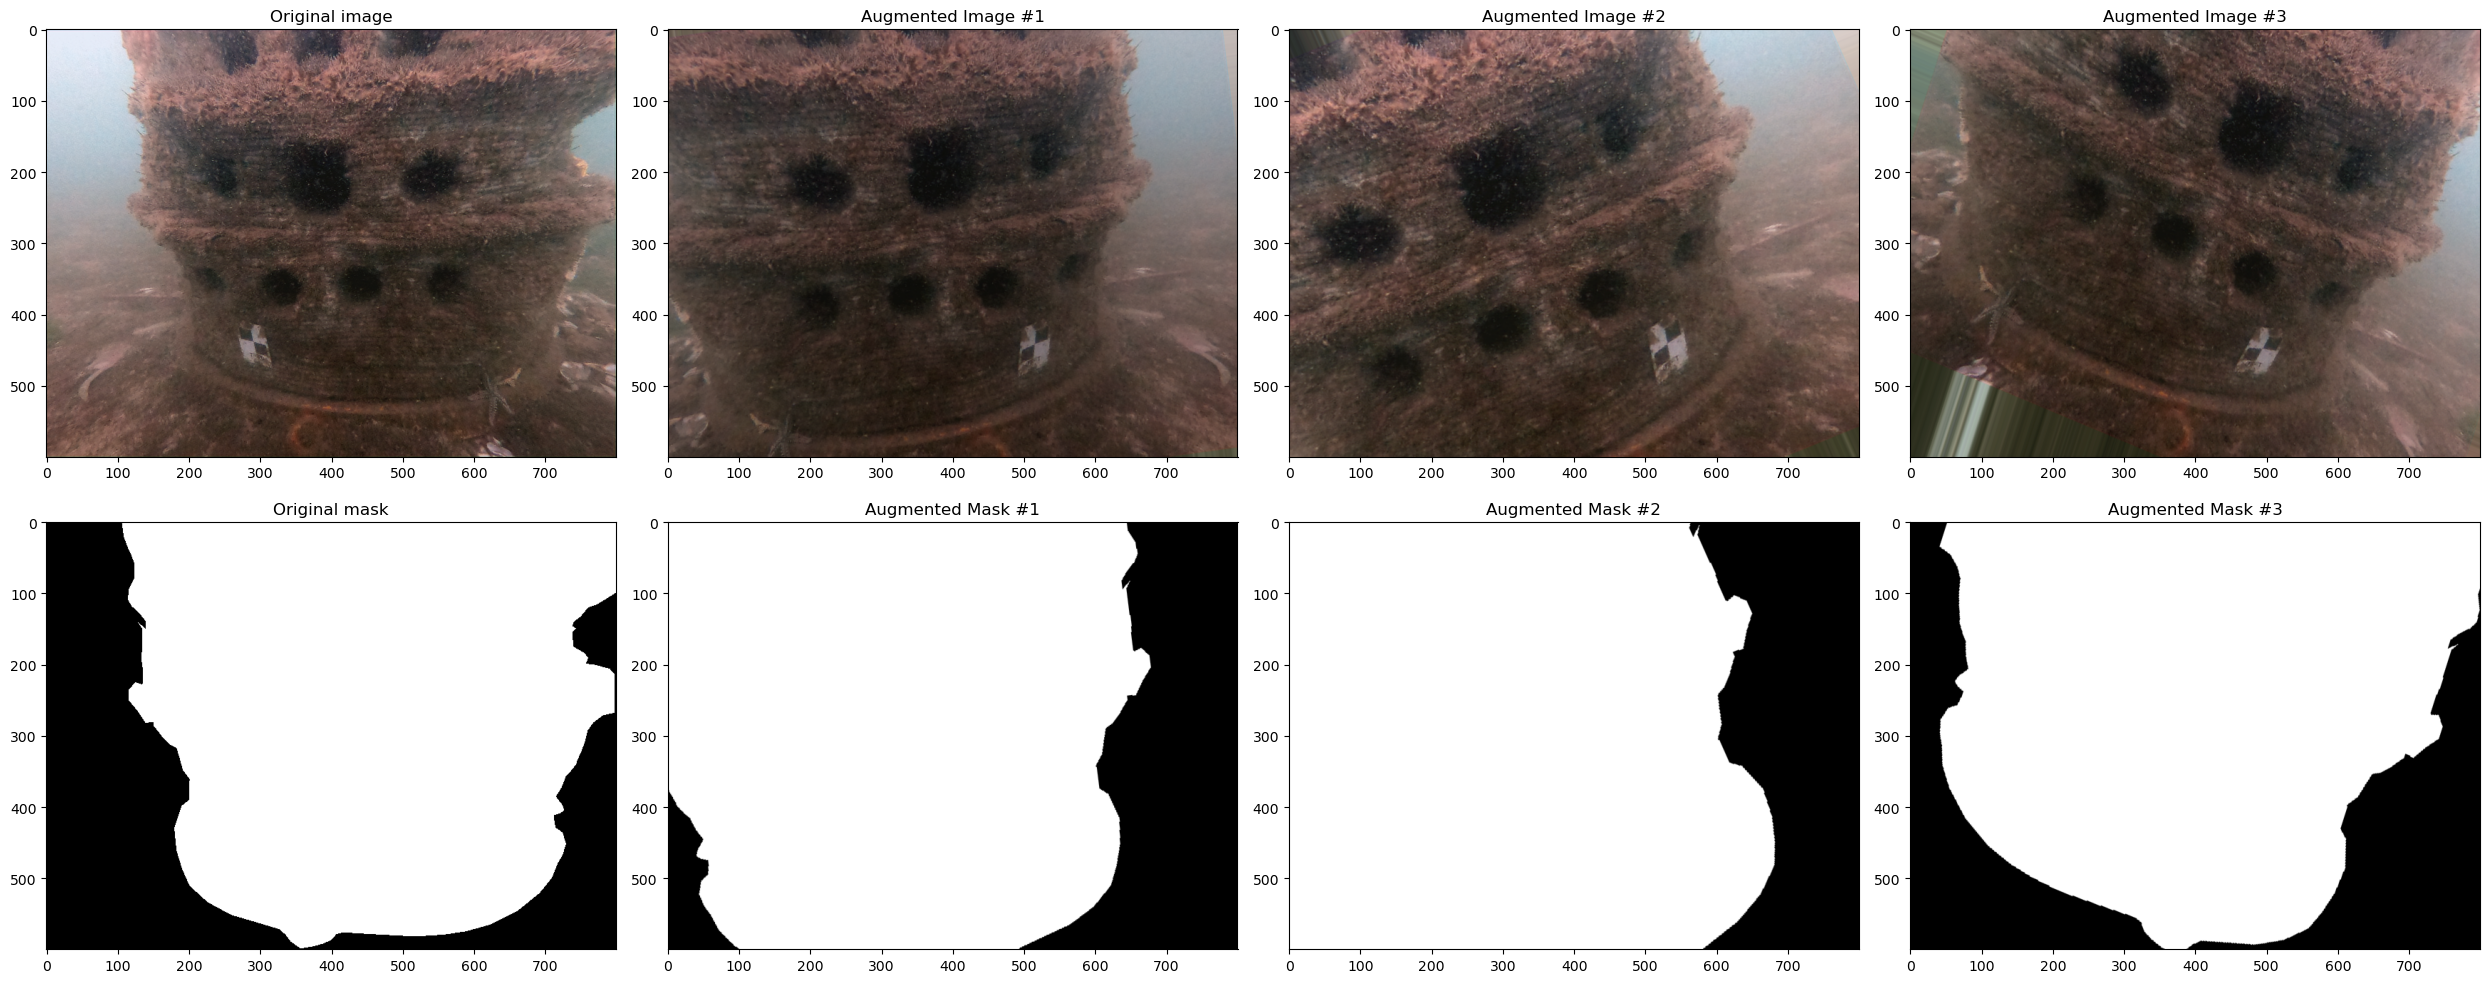

In [ ]:
from tensorflow.keras.utils import load_img
import matplotlib.pyplot as plt
from glob import glob
import random

img_paths = sorted(glob(IMGS_DIR + '\\0\\*.PNG')) 
idx = random.choice(range(0, len(img_paths)-1))

img = load_img(img_paths[idx])
img_exp = np.expand_dims(img, axis=0)
img_iter = img_gen.flow(img_exp, batch_size=1, seed = CONFIGS['SEED'])

msks_paths = sorted(glob(MSKS_DIR + '\\0\\*.PNG')) 
msk = load_img(msks_paths[idx])
msk_exp = np.expand_dims(msk, axis=0)
msk_iter = msk_gen.flow(msk_exp, batch_size=1, seed = CONFIGS['SEED'])

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(25,10))

ax[0,0].imshow(img)
ax[0,0].set_title("Original image")

ax[1,0].imshow(msk)
ax[1,0].set_title("Original mask")

for i in range(3):
    image = next(img_iter)[0]
    ax[0, i+1].set_title(f"Augmented Image #{i+1}")
    ax[0, i+1].imshow(image)

    mask = next(msk_iter)[0]
    ax[1, i+1].set_title(f"Augmented Mask #{i+1}")
    ax[1, i+1].imshow(mask)

plt.tight_layout();

#### Train and Validation Generators

In [ ]:
train_generator = zip(img_trn_dset, msk_trn_dset)
valid_generator = zip(img_vld_dset, msk_vld_dset)

##### create_run_string

In [5]:
from datetime import datetime
def create_run_string(img_size, model_name = "NN",fold=None, use_cross_val=False):
    """Create a string for each training run.

    Args:
        img_size (tuple): The size (height, width) of the images.
        model_name: (str,optional): the designation of the model. Defaults to "NN".
        fold (int, optional): The fold number for cross-validation. Defaults to None.
        use_cross_val (bool, optional): Whether or not to use cross-validation. Defaults to False.

    Returns:
        str: The string for the training run.
    """
    now = datetime.now()
    dt_string = now.strftime("%d_%b_%Hh%Mmin")
    str_run = f"{model_name}_{img_size[0]}x{img_size[1]}_DT_{dt_string}"
    if use_cross_val:
        str_run += f"_fold_{fold}"
    return str_run

##### metrics_graphs

In [6]:
def metrics_graphs(history, model, model_conf="not provided!", metrics=['loss'], y_log=False):
    """
    Plots training and validation metrics of a Keras model during training.
    Parameters:
    -----------
    history: tf.keras.callbacks.History
        Object returned by model.fit() containing training history.
    model: tf.keras.Model
        The trained machine learning model.
    conf_modelo: str, optional (default="")
        The configuration of the model (optional)
    metrics: list of str, optional (default=['loss'])
        The metrics to plot. Must be keys in the history object.
    y_log: bool, optional(default=False) 
        Whether to use logarithmic scale for the y-axis on the loss plot. 
        Defaults to False.
    """

    if not isinstance(history, tf.keras.callbacks.History):
        raise TypeError("The 'history' argument must be a tf.keras.callbacks. History object.")
    if not isinstance(model, tf.keras.Model):
        raise TypeError("The 'model' argument must be a tf.keras.Model object.")
    if not isinstance(model_conf, str):
        raise TypeError("The 'model_conf' argument must be a string.")
        
    plt.style.use('fast') 

    n_metrics = len(metrics)
    fig, axs = plt.subplots(1, n_metrics, figsize=(25, 8))

    if n_metrics == 1:
        axs = [axs]

    for i, metric in enumerate(metrics):
        if metric not in history.history or f"val_{metric}" not in history.history:
            raise ValueError(f"{metric} not found in the history object.")

        axs[i].plot(history.history[metric], "limegreen", marker=".", alpha=0.7)
        axs[i].plot(history.history[f"val_{metric}"], "orangered", marker=".", alpha=0.7)
        axs[i].set_title(f"{metric.title()} of {model.name}\nConfiguration: {model_conf}")
        axs[i].set_ylabel(metric.title())
        axs[i].set_xlabel('Epoch')
        axs[i].legend(['train', 'validation'], loc='best')
        axs[i].grid(linestyle='--', linewidth=0.4)

        xmax = np.argmax(history.history[f"val_{metric}"])
        ymax = max(history.history[f"val_{metric}"])
        text = f"{metric.title()} Val.: {ymax:.3f}"
        bbox_props = dict(boxstyle="round,pad=0.3", fc="w", ec="k", lw=0.5)
        arrowprops1 = dict(arrowstyle="->", connectionstyle="arc3,rad=0.3")
        kw = dict(xycoords='data', textcoords="offset points",
                  arrowprops=arrowprops1, bbox=bbox_props, ha="right", va="center")
        axs[i].annotate(text, xy=(xmax, ymax), xytext=(-15, -30), **kw)

        if metric == 'loss' and y_log:
            axs[i].set_yscale('log')

    plt.tight_layout()

##### callback_funcs

In [7]:
def callback_funcs(str_run, monitor_metric='val_loss', mode='min', reduce_factor=0.5,
                   reduce_patience=10, fold_n=0, additional_callbacks=[], callback_list=[]):
    """
    Creates a list of Keras callbacks to be used during model training.

    Parameters
    ----------
    str_run : str
        Prefix for the filenames of the CSVLogger and ModelCheckpoint callbacks.
    monitor_metric : str, optional
        Name of the metric to monitor for the ReduceLROnPlateau and ModelCheckpoint callbacks. 
        Default is 'loss'.
    mode : str, optional
        One of {'min', 'max', 'auto'}. 
        Specifies whether the monitored metric should be minimized, maximized, or inferred automatically for the ModelCheckpoint callback. 
        Default is 'min'.
    reduce_factor : float, optional
        Factor by which to reduce the learning rate when there is no improvement in monitored metric after reduce_patience epochs.
        Default is 0.5.
    reduce_patience : int, optional
        Number of epochs with no improvement after which to reduce the learning rate for the ReduceLROnPlateau callback.
        Default is 10.
    additional_callbacks : list, optional
        List of additional Keras callbacks to be added to the output list.
        Default is [].
    callback_list : list, optional
        List of callback names to activate. 
        Available options are 'csv_logger', 'reduce_lr', and 'checkpoint'.
        Default is [] which activates all callbacks.

    Returns
    -------
    list
        A list of Keras callbacks to be used during model training.

    """   

    # Learning Schedule
    # Reduce learning rate when there is no improvement in monitored metric after a certain number of epochs
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor=monitor_metric,
        factor=reduce_factor,
        mode=mode,
        patience=reduce_patience,
        verbose=1,
        min_lr=1e-6)
    
    # Training Logs
    # Log training metrics to a CSV file
    csv_logger = tf.keras.callbacks.CSVLogger(
        os.path.join(LOGS, str_run + '.csv'),
        separator=",",
        append=True)
    
    # Model Checkpoint
    # Save the best model based on monitored metric on validation data
    checkpoint_filepath = os.path.join(CHCKPNT_MODELS, str_run +'.h5')
    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_best_only=True,
        mode=mode,
        verbose=1,
        monitor=monitor_metric)
    
    callbacks = []
    
    if not callback_list:
        callbacks = [csv_logger, reduce_lr, checkpoint] + additional_callbacks
    else:
        if 'csv_logger' in callback_list:
            callbacks.append(csv_logger)
        if 'reduce_lr' in callback_list:
            callbacks.append(reduce_lr)
        if 'checkpoint' in callback_list:
            callbacks.append(checkpoint)
        callbacks += additional_callbacks
    
    return callbacks

In [15]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
#from segmentation_models.metrics import iou_score        # test different iou score calculation
# from tensorflow.keras.metrics import MeanIoU           # or Jaccard Index
from tensorflow.keras.metrics import Precision         
from tensorflow.keras.metrics import Recall

optimizer = Adam()
#optimizer = SGD(momentum=0.9, clipvalue=0.1)
loss_fn = tf.keras.losses.binary_crossentropy
model = DeeplabV3Plus(image_size=IMG_SIZE[0], num_classes=1)

model.compile(optimizer = optimizer, 
              loss = loss_fn,
              metrics= ['accuracy', Precision(thresholds=0.5), Recall(thresholds=0.5)]
             )

## Learning Rate Finder

In [16]:
train_generator = zip(img_trn_dset, msk_trn_dset)
valid_generator = zip(img_vld_dset, msk_vld_dset)

In [ ]:
%%time
from lr_find import LrFinder

# Instantiate LrFinder
lr_find = LrFinder(model, optimizer, loss_fn)
# Start range_test
lr_find.range_test(train_generator, num_iter=1000)

Min numerical gradient: 1.61E-07
Min loss divided by 10: 1.20E-08


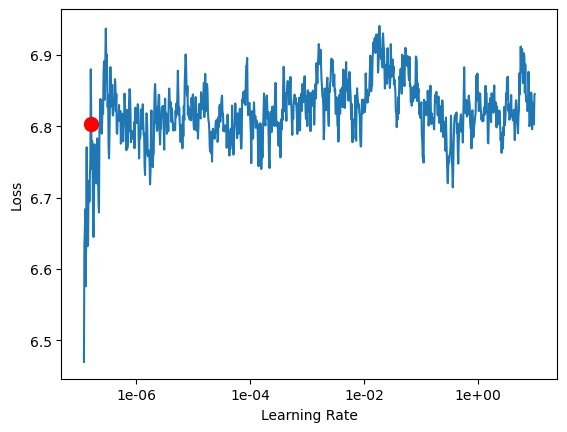

In [38]:
lr_find.plot_lrs(skip_end=0, suggestion=True)

In [18]:
from one_cycle import OneCycleLr

max_lr = 1e-6

one_c = OneCycleLr(max_lr=max_lr, steps_per_epoch=(img_trn_dset.n // BATCH_SIZE)*10, epochs=1000)

# Fitting Model

### string_run

In [19]:
def string_run(model_name = 'NET', fold = [], val_cruz = False):
    """
    Creates a string for the run.
    """
    from datetime import datetime
    now = datetime.now()
    dt_string = now.strftime("%d_%b_%Hh%Mmin")
    str_run = f"{model_name}_DT_{dt_string}"
    if val_cruz == True:
        str_run = str_run + "_fold_" + str(fold)
    print(f'run designation: \033[1m{str_run}\033[0m')
    return str_run

In [20]:
str_run = string_run(model_name = 'DeepLabV3')
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor = 'loss',
                                              factor = 0.5,    # fator de reducao tx. aprendizagem
                                              mode = 'min',    # tx. apr. diminui se IoU nao aumentar
                                              patience = 20,   # epocas ate reducao tx. aprendizagem
                                              verbose = 1,     # verbosidade
                                              min_lr = 1e-6)   # tx.aprendizagem inicial = 0.1

chckpnt_cb = keras.callbacks.ModelCheckpoint(filepath = os.path.join(CHCKPNT_MODELS, str_run + '.h5'),
                                             save_best_only = True,
                                             mode = 'max',
                                             verbose = 1, 
                                             monitor = "val_accuracy")

run designation: DeepLabV3_DT_13_Mar_20h27min


In [21]:
%%time
# 🏋🏽 trains the model
history = model.fit(train_generator,
                    validation_data = valid_generator,
                    epochs = 1000,
                    batch_size = BATCH_SIZE,
                    verbose = 1,
                    steps_per_epoch = (img_trn_dset.n // BATCH_SIZE)*10,
                    validation_steps = img_vld_dset.n // BATCH_SIZE,
                    validation_batch_size = BATCH_SIZE,
                    callbacks = [chckpnt_cb, one_c])

Epoch 1/1000
70/70 [==============================] - ETA: 0s - loss: 5.6612 - accuracy: 0.4771 - precision_1: 0.4795 - recall_1: 0.8836
Epoch 1: val_accuracy improved from -inf to 0.45018, saving model to C:\Users\tiago\miniconda3\envs\tf2_10\reefs\checkpoints\deeplabv3\DeepLabV3_DT_13_Mar_20h27min.h5
70/70 [==============================] - 36s 396ms/step - loss: 5.6612 - accuracy: 0.4771 - precision_1: 0.4795 - recall_1: 0.8836 - val_loss: 7.8741 - val_accuracy: 0.4502 - val_precision_1: 0.4540 - val_recall_1: 0.9763
Epoch 2/1000
70/70 [==============================] - ETA: 0s - loss: 5.6383 - accuracy: 0.4782 - precision_1: 0.4820 - recall_1: 0.8827
Epoch 2: val_accuracy improved from 0.45018 to 0.47664, saving model to C:\Users\tiago\miniconda3\envs\tf2_10\reefs\checkpoints\deeplabv3\DeepLabV3_DT_13_Mar_20h27min.h5
70/70 [==============================] - 22s 313ms/step - loss: 5.6383 - accuracy: 0.4782 - precision_1: 0.4820 - recall_1: 0.8827 - val_loss: 7.9792 - val_accuracy: 0

## End Training

DeepLabV3_DT_13_Mar_20h27min


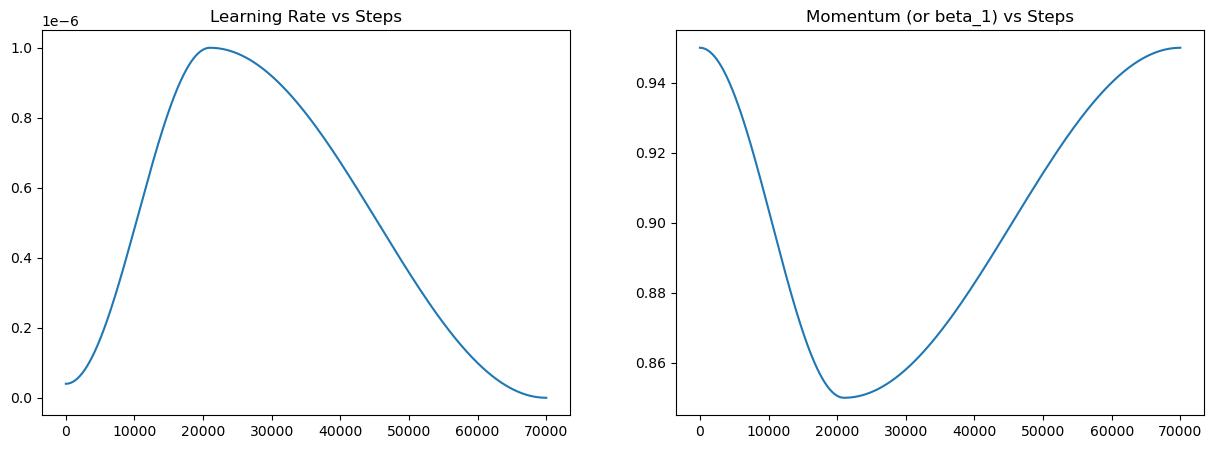

In [22]:
# to plot the learning_rate & momentum(or beta_1) graphs
print(str_run)
one_c.plot_lrs_moms()

C:\Users\tiago\AppData\Local\Temp\ipykernel_14848\1626363295.py:67: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax2.set_ylim(None)


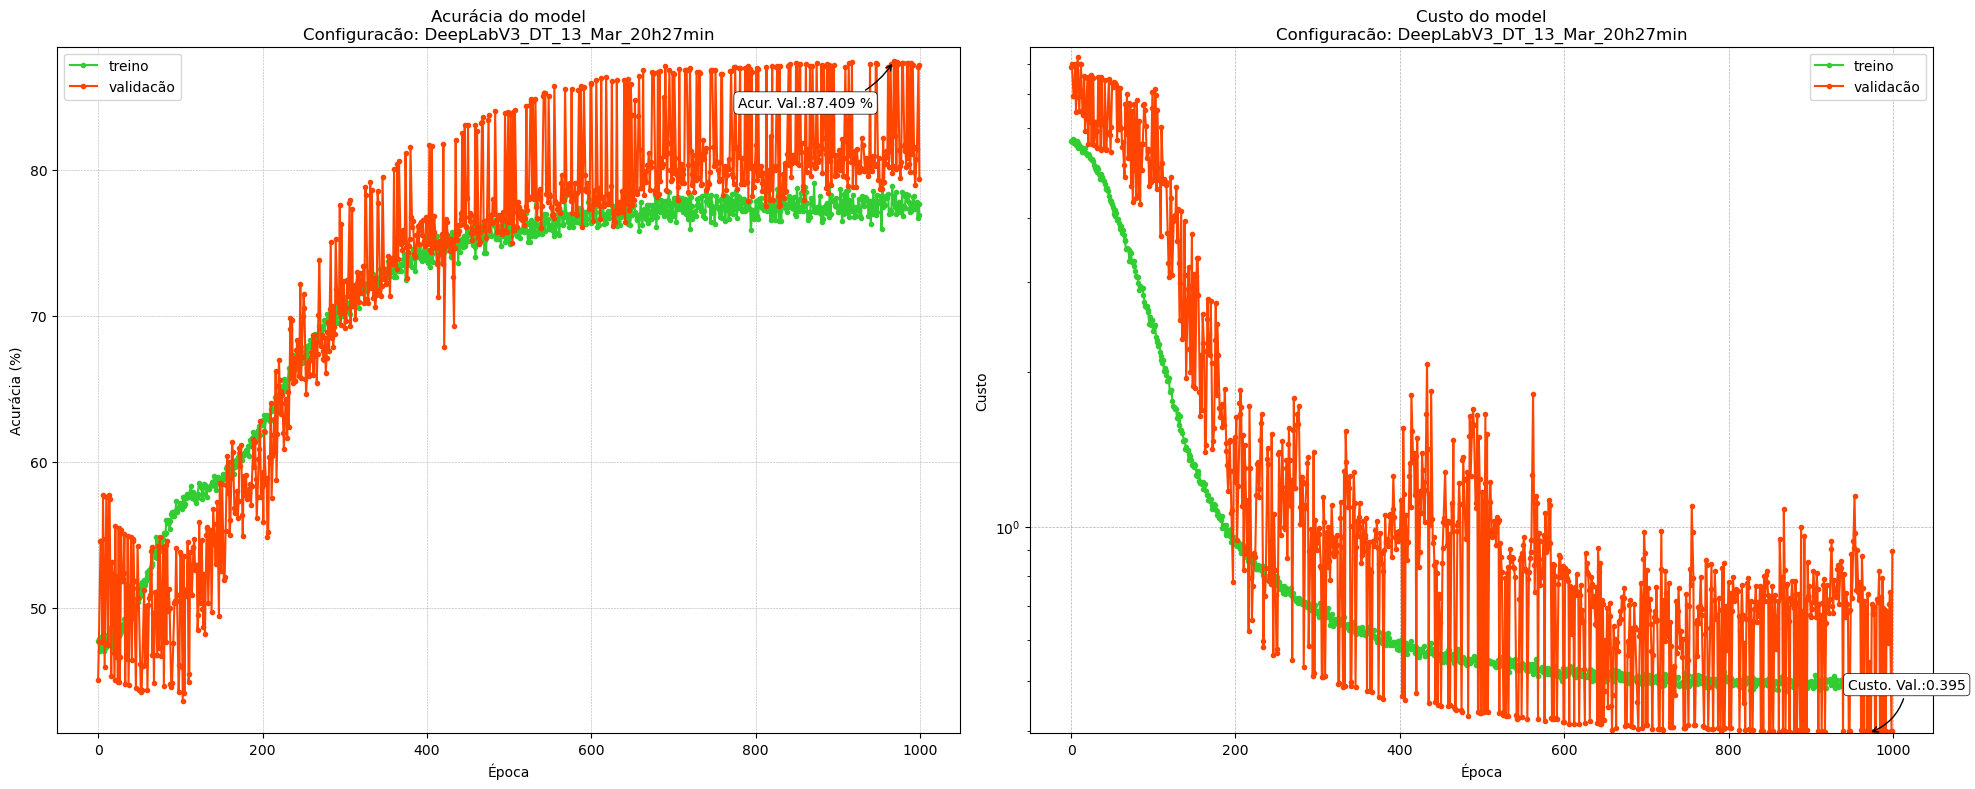

In [24]:
graficos_metricas(history, model, conf_modelo = str_run, iou = False, y_log = True)

C:\Users\tiago\AppData\Local\Temp\ipykernel_13400\1626363295.py:67: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax2.set_ylim(None)


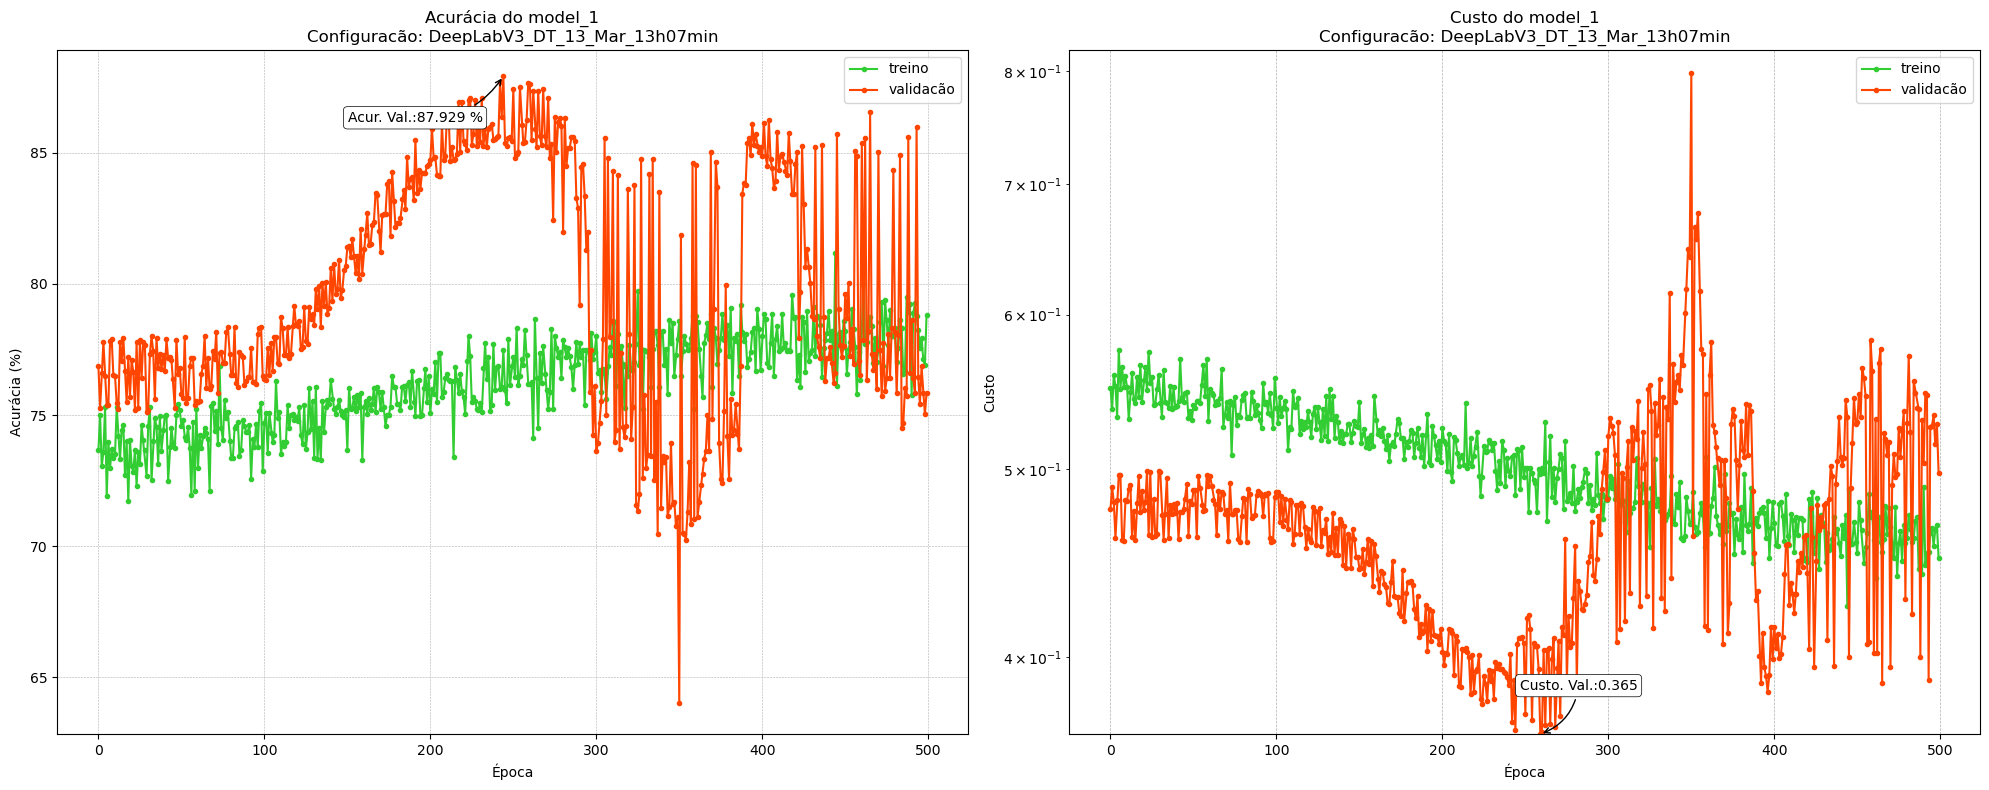

In [100]:
graficos_metricas(history, model, conf_modelo = str_run, iou = False, y_log = True)

In [23]:
def graficos_metricas(history, model, conf_modelo, iou = False, y_log = False):
    """

    """
    plt.style.use('fast') 

    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,8))

    if iou == True:
        # Cria Gráfico de Intersecão sobre a União (IoU) ou distância de Jaccard 
        ax1.plot(np.array(history.history['iou_score'])*100,"limegreen",  marker =".")
        ax1.plot(np.array(history.history['val_iou_score'])*100, "orangered" ,  marker =".")
        ax1.set_title('Indíce de Jaccard (IoU) do ' + model.name + '\n'+ "Configuracão: "+ conf_modelo)
        ax1.set_ylabel('Indíce de Jaccard (%)')
        ax1.set_xlabel('Época')
        ax1.legend(['treino', 'validacão'], loc = 'best')
        ax1.grid(linestyle = '--', linewidth = 0.4)

        # Cria caixa indicando o máximo de acurácia de validacão
        # (objetivo: criar nota com valor relevante dentro do espaco do gráfico)
        xmax = np.argmax(history.history['val_iou_score'])
        ymax = max(history.history['val_iou_score'])*100
        text= "IoU. Val.:{:.3f} %".format(ymax)
        # lw, linewidth; fc, facebolor; ec, edgecolor
        bbox_props = dict(boxstyle="round,pad=0.3", fc="w", ec="k", lw=0.5)   
        arrowprops1 = dict(arrowstyle="->",connectionstyle="arc3,rad=0.3")
        kw = dict(xycoords='data',textcoords="offset points",
                  arrowprops=arrowprops1, bbox=bbox_props, ha="right", va="center")
        ax1.annotate(text, xy=(xmax, ymax), xytext=(-15,-30), **kw)
        ax1.set_ylim(top = max(history.history['val_iou_score'] + 
                                history.history['iou_score'])*100 + 1)
    else:
        # Cria Gráfico de Acurácia
        ax1.plot(np.array(history.history['accuracy'])*100,"limegreen",  marker =".")
        ax1.plot(np.array(history.history['val_accuracy'])*100, "orangered" ,  marker =".")
        ax1.set_title('Acurácia do ' + model.name + '\n'+ "Configuracão: "+ conf_modelo)
        ax1.set_ylabel('Acurácia (%)')
        ax1.set_xlabel('Época')
        ax1.legend(['treino', 'validacão'], loc = 'best')
        ax1.grid(linestyle = '--', linewidth = 0.4)

        # Cria caixa indicando o máximo de acurácia de validacão
        # (objetivo: criar nota com valor relevante dentro do espaco do gráfico)
        xmax = np.argmax(history.history['val_accuracy'])
        ymax = max(history.history['val_accuracy'])*100
        text= "Acur. Val.:{:.3f} %".format(ymax)
        # lw, linewidth; fc, facebolor; ec, edgecolor
        bbox_props = dict(boxstyle="round,pad=0.3", fc="w", ec="k", lw=0.5)   
        arrowprops1 = dict(arrowstyle="->",connectionstyle="arc3,rad=0.3")
        kw = dict(xycoords='data',textcoords="offset points",
                  arrowprops=arrowprops1, bbox=bbox_props, ha="right", va="center")
        ax1.annotate(text, xy=(xmax, ymax), xytext=(-15,-30), **kw)
        ax1.set_ylim(top = max(history.history['val_accuracy'] + 
                               history.history['accuracy'])*100 + 1)
  
    # Cria Gráfico de Custo
    ax2.plot(history.history['loss'], "limegreen",  marker =".")
    ax2.plot(history.history['val_loss'],"orangered" ,  marker =".")
    ax2.set_title('Custo do '+ model.name +'\n'+ "Configuracão: "+ conf_modelo)
    ax2.set_ylabel('Custo')
    ax2.set_xlabel('Época')
    ax2.legend(['treino', 'validacão'], loc = 'best')
    ax2.grid(linestyle = '--', linewidth = 0.5)
    ax2.set_ylim(ymin=0)
    if y_log == True:
        ax2.set_yscale('log')
        ax2.set_ylim(None)
        
    # Cria caixa indicando o minímo de custo de validacão
    xmin = np.argmin(history.history['val_loss'])
    ymin = min(history.history['val_loss'])
    text2= "Custo. Val.:{:.3f}".format(ymin)
    bbox_props2 = dict(boxstyle="round,pad=0.3", fc="w", ec="k", lw = 0.5)
    arrowprops2 = dict(arrowstyle="->",connectionstyle="arc3,rad=-0.3")
    kw2 = dict(xycoords='data',textcoords="offset points",
               arrowprops=arrowprops2, bbox=bbox_props2, ha="right", va="center")
    ax2.annotate(text2, xy=(xmin, ymin), xytext=(70, 35), **kw2)
    plt.tight_layout()

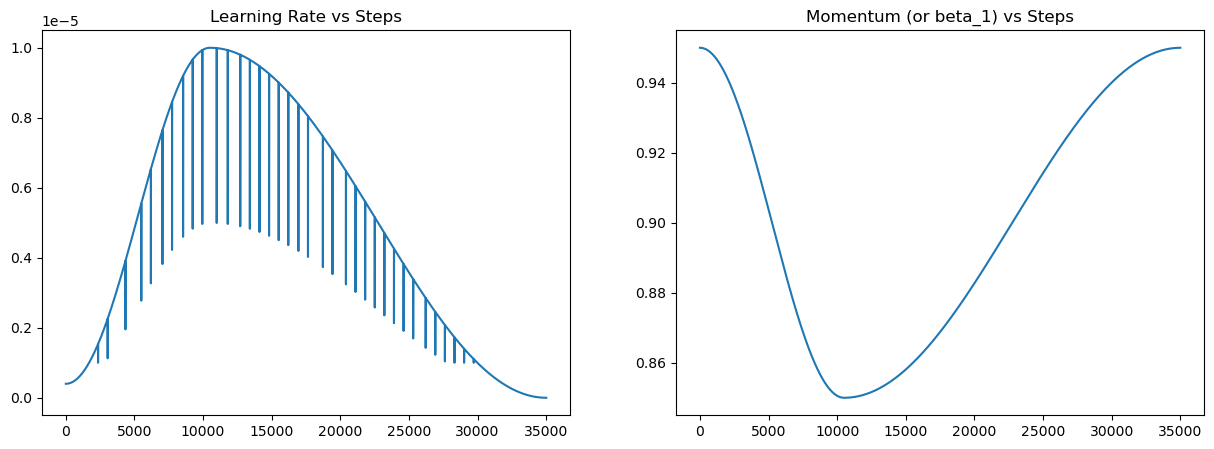

In [58]:
one_c.plot_lrs_moms()

C:\Users\tiago\AppData\Local\Temp\ipykernel_20304\1626363295.py:67: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax2.set_ylim(None)


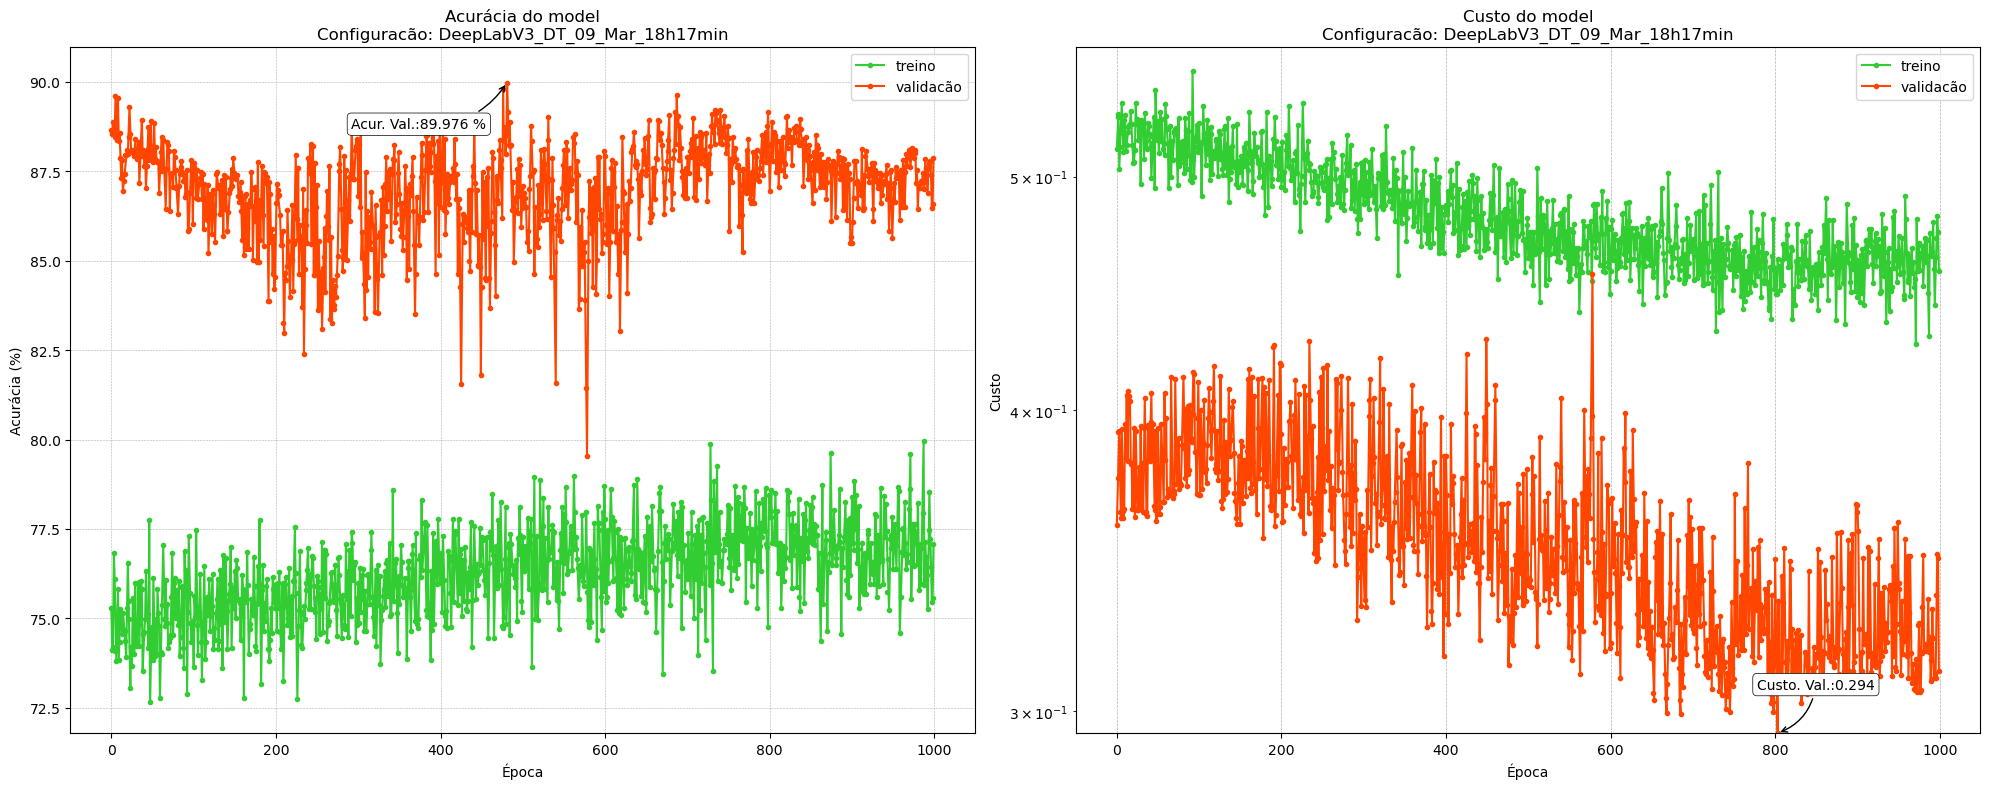

In [59]:
graficos_metricas(history, model, conf_modelo = str_run, iou = False, y_log = True)

C:\Users\tiago\AppData\Local\Temp\ipykernel_35180\1626363295.py:67: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax2.set_ylim(None)


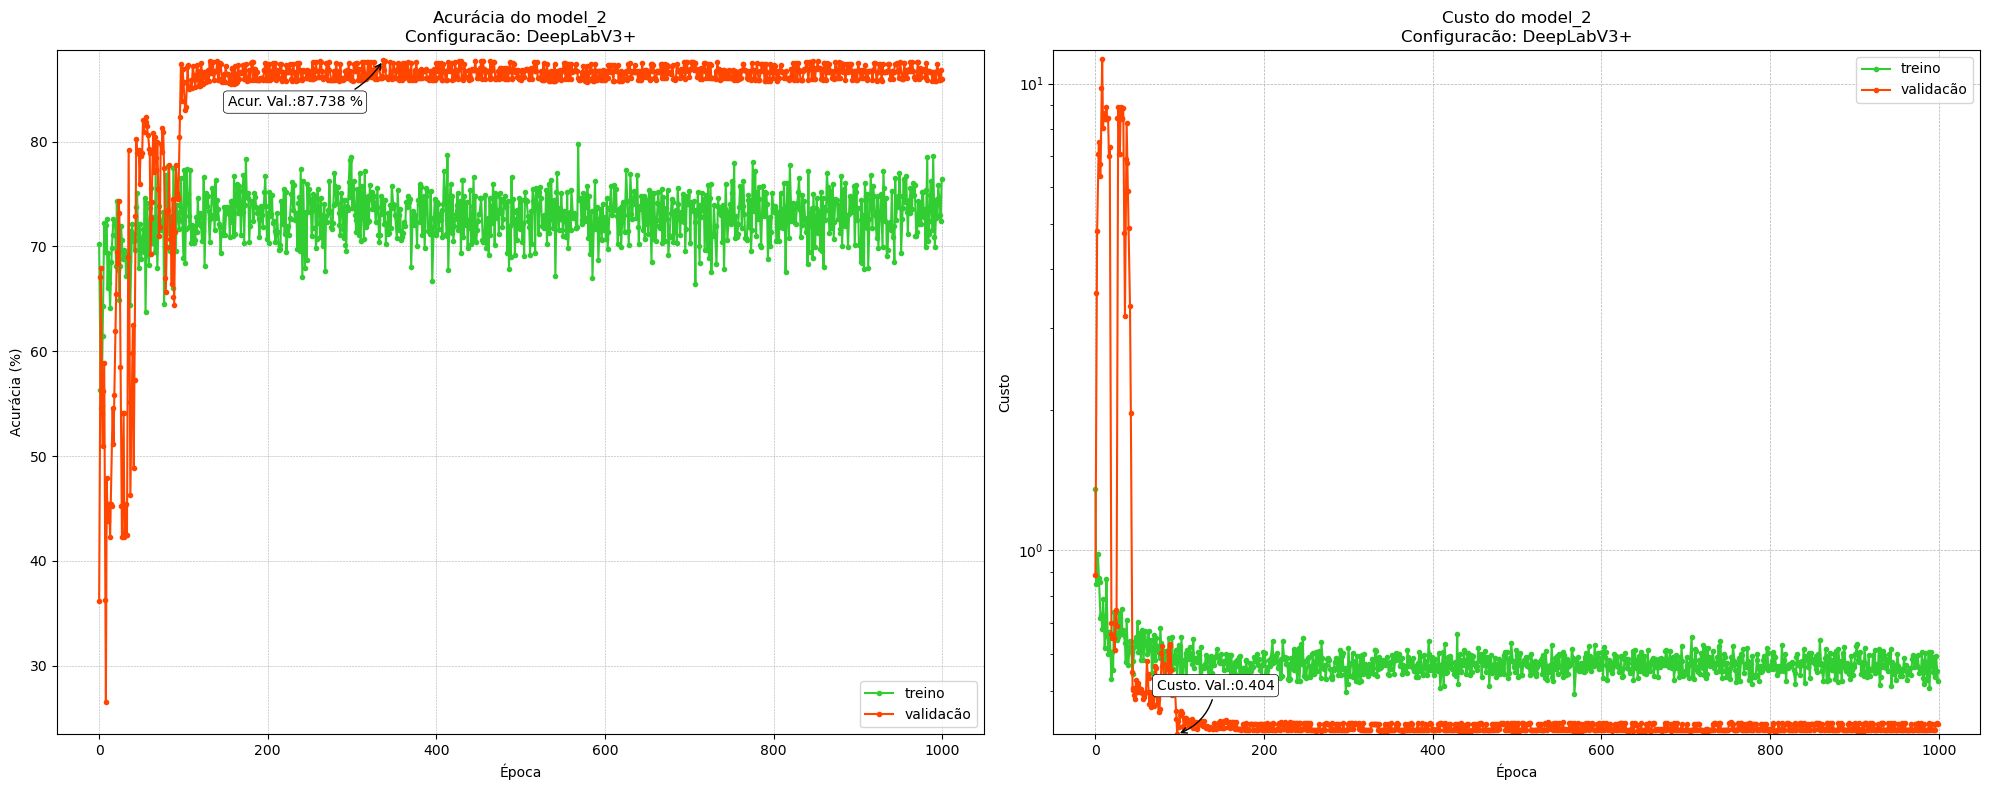

In [43]:
graficos_metricas(history, model, conf_modelo = "DeepLabV3+", iou = False, y_log = True)

# Inference

In [25]:
loaded_model = keras.models.load_model(CHCKPNT_MODELS + '\\'+str_run+'.h5')

In [26]:
model = loaded_model

1/1 [==============================] - 0s 29ms/step


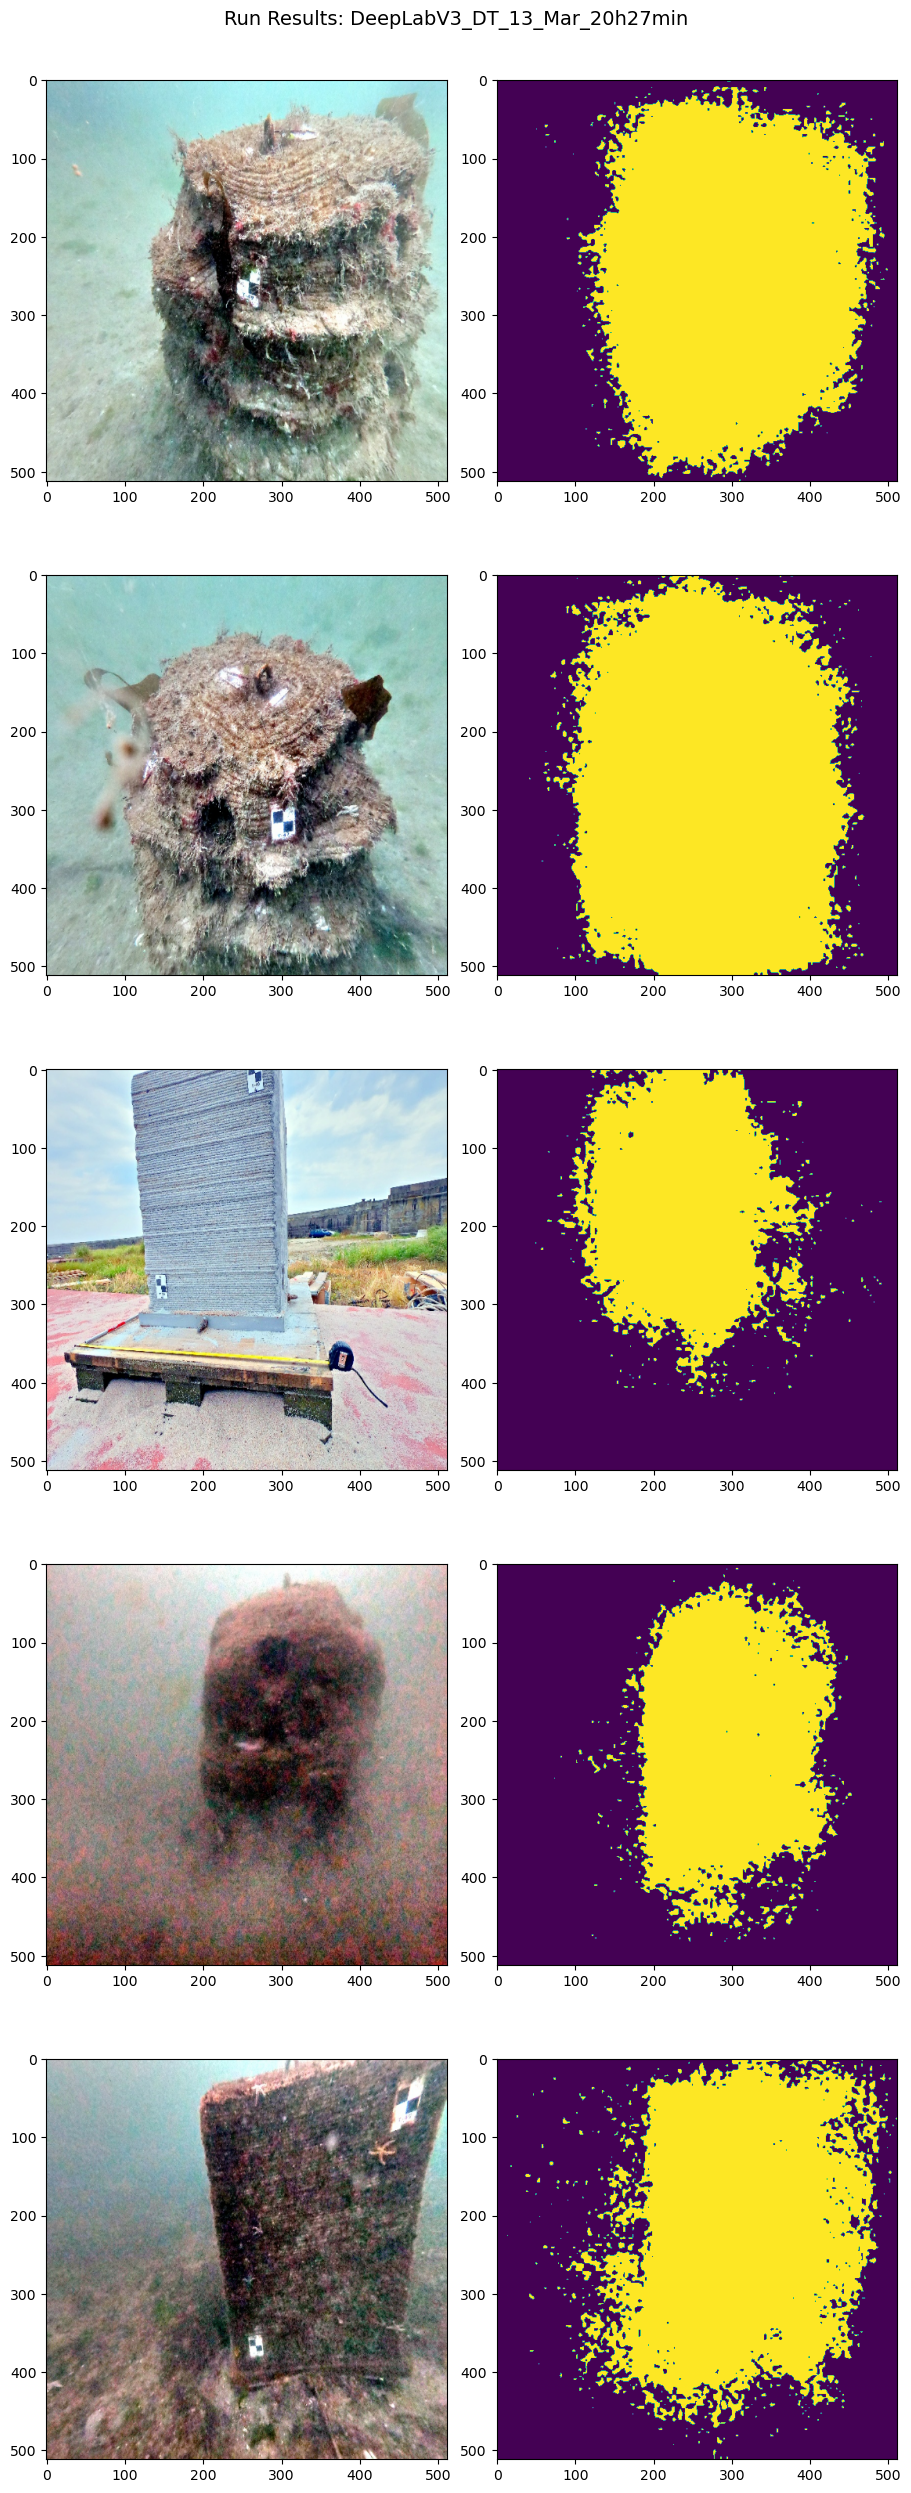

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import random
imgs_path = sorted(glob(NO_LABEL_DIR + '\\1\\*'))
pred_list = list()
img_list = list()
img_idx = random.sample(range(len(imgs_path)), 5)
for i in range(5):
    img = tf.io.decode_jpeg(tf.io.read_file(imgs_path[img_idx[i]]), channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img_list.append(img)
    img_exp = tf.expand_dims(img, axis=0)
    img_exp = tf.cast(img_exp, dtype=tf.float32) / tf.constant(256, dtype=tf.float32)
    pred = model.predict(img_exp)
    pred_list.append(pred[0] > 0.5)
fig, axs = plt.subplots(5, 2, figsize=(9,25), constrained_layout=True)
j = 0
for img, pred in zip(img_list,pred_list):
    axs[j, 0].imshow(np.asarray(img).astype("int"))
    axs[j, 1].imshow(np.asarray(pred).astype("int"))
    j += 1
    plt.suptitle('Run Results: '+ str_run, fontsize=14);
    plt.tight_layout;